**1.load and explore the dataset**

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
from torchvision import transforms, datasets

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# === V1: Train with original dataset ===

In [2]:
# Point pyhton to data folder.(images are in folders)
DATA_DIR = "data/chest_xray"
TRAIN_DIR = "data/chest_xray/train"
# TRAIN_DIR = os.path.join(DATA_DIR, "train")

In [3]:
os.listdir(TRAIN_DIR)

['NORMAL', 'PNEUMONIA']

In [4]:
# Count images per class
def count_images(folder):
    counts = {}
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        counts[label] = len(os.listdir(label_path))
    return counts

train_counts = count_images(TRAIN_DIR)
train_counts

{'NORMAL': 1341, 'PNEUMONIA': 3875}

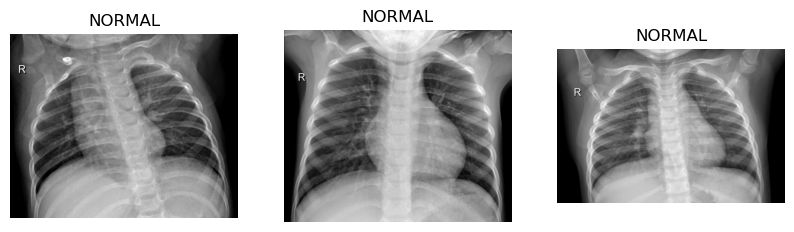

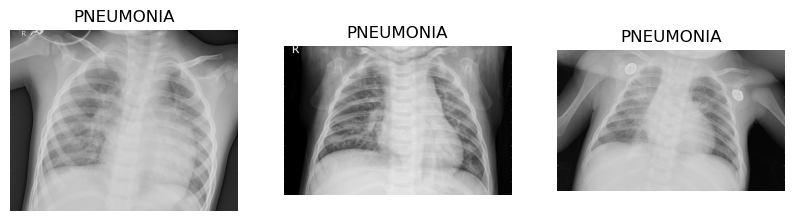

In [5]:
# Show sample images

def show_images(folder, label, n=3):
    label_path = os.path.join(folder, label)
    images = random.sample(os.listdir(label_path), n)

    plt.figure(figsize=(10,3))
    for i, img_name in enumerate(images):
        img_path = os.path.join(label_path, img_name)
        img = Image.open(img_path)

        plt.subplot(1,n,i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')

    plt.show()

show_images(TRAIN_DIR, "NORMAL")
show_images(TRAIN_DIR, "PNEUMONIA")

**The dataset is imbalanced with more pneumonia images than normal.**

**X-ray images vary in resolution and orientation.**

**Pneumonia cases often show diffuse opacity compared to normal lungs.**

In [6]:
torch.__version__

'2.5.1'

In [7]:
# Resize the images, convert pixels to numbers
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],std=[0.5])
])

In [8]:
# Load the dataset using imagefolder
train_dataset = datasets.ImageFolder(
    root = TRAIN_DIR, #did this manually in the first step
    transform=transform
)

In [9]:
len(train_dataset)

5216

In [10]:
# Images shape
image, label = train_dataset[0]
image.shape, label

(torch.Size([3, 224, 224]), 0)

In [11]:
train_dataset.classes

['NORMAL', 'PNEUMONIA']

In [12]:
# Create a dataloader
from torch.utils.data import DataLoader

g = torch.Generator()
g.manual_seed(42)

train_loader = DataLoader(
    train_dataset,
    batch_size = 32, #fed 32 images to the model in one time, use small bathes to save time
    shuffle = True,
    drop_last = True,
    generator = g
)

In [13]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90588236].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

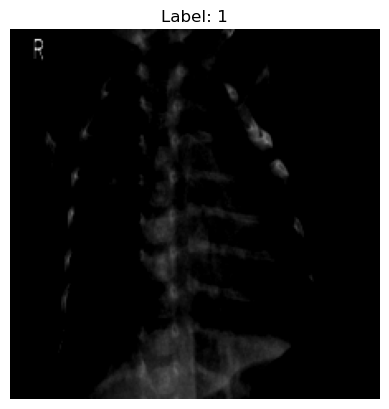

In [14]:
# Visualize preprocessed images
img = images[0]
img = img.permute(1, 2, 0)  # CHW → HWC

plt.imshow(img)
plt.title(f"Label: {labels[0].item()}")
plt.axis('off')

**2. Define the transfer learning and train the model**

In [15]:
model = models.resnet18(pretrained=True)

D:\bootcamp\envs\torch-ds\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\bootcamp\envs\torch-ds\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# Freeze the convolution layers
for param in model.parameters():
    param.requires_grad = False

In [17]:
# Keep the last layer for classifocation. trim the classes into 2 which is NORMAL and PNEUMONIA
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

In [18]:
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [19]:
# Define loss function
criterion = nn.CrossEntropyLoss()

In [20]:
# Define the optimizer to only the final layer
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [21]:
# Model training
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() #clears old gradients

        outputs = model(images) 
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/3, Loss: 0.2443
Epoch 2/3, Loss: 0.1605
Epoch 3/3, Loss: 0.1513


**3. Validation**

In [22]:
VAL_DIR = "data/chest_xray/val"

In [23]:
# Load the validation dataset into imageloader
from torchvision import datasets
val_dataset = datasets.ImageFolder(
    root = VAL_DIR,
    transform = transform
)

In [24]:
len(val_dataset)

16

In [25]:
val_dataset.classes

['NORMAL', 'PNEUMONIA']

In [26]:
# Data loader
val_loader = DataLoader(
    val_dataset,
    batch_size = 32,
    shuffle = False
)

In [27]:
# Switch model to evaluation mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
accuracy

0.8125

In [42]:
from sklearn.metrics import confusion_matrix, classification_report

model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        probs = F.softmax(outputs, dim=1)  # convert logits to probabilities
        pneumonia_probs = probs[:, 1]      # probability of class 1 (PNEUMONIA)

        all_probs.extend(pneumonia_probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [43]:
cm = confusion_matrix(all_labels, all_preds)
cm

array([[5, 3],
       [0, 8]])

In [44]:
print(classification_report(all_labels, all_preds, target_names=["NORMAL","PNEUMONIA"]))

              precision    recall  f1-score   support

      NORMAL       1.00      0.62      0.77         8
   PNEUMONIA       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16



**4. Threshold tuning**

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.1, 0.9, 0.1)
for t in thresholds:
    preds = (np.array(all_probs) > t).astype(int)

    precision = precision_score(all_labels, preds)
    recall = recall_score(all_labels, preds)
    f1 = f1_score(all_labels, preds)

    print(f"Threshold: {t:.1f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")
# Changing threshold from 0.1 → 0.8 doesn’t flip any prediction. Therefore, Recall remain almost identical.

Threshold: 0.1 | Precision: 0.50 | Recall: 1.00 | F1: 0.67
Threshold: 0.2 | Precision: 0.50 | Recall: 1.00 | F1: 0.67
Threshold: 0.3 | Precision: 0.57 | Recall: 1.00 | F1: 0.73
Threshold: 0.4 | Precision: 0.67 | Recall: 1.00 | F1: 0.80
Threshold: 0.5 | Precision: 0.73 | Recall: 1.00 | F1: 0.84
Threshold: 0.6 | Precision: 0.89 | Recall: 1.00 | F1: 0.94
Threshold: 0.7 | Precision: 0.89 | Recall: 1.00 | F1: 0.94
Threshold: 0.8 | Precision: 1.00 | Recall: 0.88 | F1: 0.93


In [46]:
# Testing extreme threshold
thresholds = np.arange(0.85, 0.99, 0.01)
for t in thresholds:
    preds = (np.array(all_probs) > t).astype(int)

    precision = precision_score(all_labels, preds)
    recall = recall_score(all_labels, preds)
    f1 = f1_score(all_labels, preds)

    print(f"Threshold: {t:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")

Threshold: 0.85 | Precision: 1.00 | Recall: 0.88 | F1: 0.93
Threshold: 0.86 | Precision: 1.00 | Recall: 0.88 | F1: 0.93
Threshold: 0.87 | Precision: 1.00 | Recall: 0.88 | F1: 0.93
Threshold: 0.88 | Precision: 1.00 | Recall: 0.88 | F1: 0.93
Threshold: 0.89 | Precision: 1.00 | Recall: 0.88 | F1: 0.93
Threshold: 0.90 | Precision: 1.00 | Recall: 0.88 | F1: 0.93
Threshold: 0.91 | Precision: 1.00 | Recall: 0.88 | F1: 0.93
Threshold: 0.92 | Precision: 1.00 | Recall: 0.88 | F1: 0.93
Threshold: 0.93 | Precision: 1.00 | Recall: 0.88 | F1: 0.93
Threshold: 0.94 | Precision: 1.00 | Recall: 0.88 | F1: 0.93
Threshold: 0.95 | Precision: 1.00 | Recall: 0.88 | F1: 0.93
Threshold: 0.96 | Precision: 1.00 | Recall: 0.88 | F1: 0.93
Threshold: 0.97 | Precision: 1.00 | Recall: 0.75 | F1: 0.86
Threshold: 0.98 | Precision: 1.00 | Recall: 0.75 | F1: 0.86
Threshold: 0.99 | Precision: 1.00 | Recall: 0.50 | F1: 0.67


In [47]:
# Print the probability
for prob, label in zip(all_probs, all_labels):
    print(f"Prob: {prob:.4f}, Label: {label}")

Prob: 0.5910, Label: 0
Prob: 0.3888, Label: 0
Prob: 0.2007, Label: 0
Prob: 0.7785, Label: 0
Prob: 0.2777, Label: 0
Prob: 0.5987, Label: 0
Prob: 0.4795, Label: 0
Prob: 0.3881, Label: 0
Prob: 0.9961, Label: 1
Prob: 0.9956, Label: 1
Prob: 0.9960, Label: 1
Prob: 0.9878, Label: 1
Prob: 0.9628, Label: 1
Prob: 0.9909, Label: 1
Prob: 0.9893, Label: 1
Prob: 0.7881, Label: 1


### ==================================================================
## Observation

### Recall = 1.00 in many threshold, because:

- Small validation set(16)
- Over confident model
- Possibly overfitting

**(The validation set contains only 16 samples, which limits the statistical reliability of threshold tuning and performance estimates.)**

###  Why Threshold Tuning Looks “Weird”

1. Very small validation set: only 8 Normal + 8 Pneumonia images (16 total)

2. Probabilities are concentrated:

- Normal images mostly between 0.2–0.78

- Pneumonia images mostly between 0.78–0.996

3. When sweep thresholds:

- Threshold < 0.3881 → all Normal predicted as Pneumonia → FP ↑ → precision low

- Threshold ~0.78 → last Pneumonia (0.7881) predicted as Normal → FN ↑ → recall drops

- Because there are so few images, F1 changes drastically even if threshold changes slightly

### Alterantive

- Merge train and validation set, create validation split
- Retrain the model
- Tune threshold on new validation
- Evaluate on test set
### ==================================================================

# === V2: Train with merged train+val and new stratified validation split ===

**5. Merge train and validation set**

In [49]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Load the dataset separately
train_dataset_full = datasets.ImageFolder(
    root = TRAIN_DIR,
    transform=transform
)
val_dataset_full = datasets.ImageFolder(
    root = VAL_DIR,
    transform=transform
)

# Combine them
combined_dataset = train_dataset_full + val_dataset_full

In [50]:
# Because dataset is unbalanced, we need to create stratified split
targets = [label for _, label in combined_dataset]

train_idx, val_idx = train_test_split(
    np.arange(len(targets)),
    test_size = 0.2,
    stratify = targets,
    random_state = 42
)

train_dataset_v2 = Subset(combined_dataset, train_idx)
val_dataset_v2 = Subset(combined_dataset, val_idx)

In [51]:
# Create Dataloaders
g = torch.Generator()
g.manual_seed(42)

train_loader_v2 = DataLoader(
    train_dataset_v2,
    batch_size = 32, #fed 32 images to the model in one time, use small bathes to save time
    shuffle = True,
    drop_last = True,
    generator = g
)

val_loader_v2 = DataLoader(
    val_dataset_v2,
    batch_size = 32, #fed 32 images to the model in one time, use small bathes to save time
    shuffle = False,
    generator = g
)

In [52]:
# Load the test set
TEST_DIR = "data/chest_xray/test"

test_dataset = datasets.ImageFolder(
    root = TEST_DIR,
    transform=transform
)

In [53]:
#  sanity check
print(len(train_dataset_v2))
print(len(val_dataset_v2))
print(len(test_dataset))

4185
1047
624


**6. Retrain the model**

In [54]:
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_v2:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # clears old gradients

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # Track total loss and correct predictions
        running_loss += loss.item() * images.size(0)        # total loss for this batch
        _, preds = torch.max(outputs, 1)                    # predicted classes
        correct += (preds == labels).sum().item()          # count correct predictions
        total += labels.size(0)                             # count total examples

    # Compute average loss and accuracy for the epoch
    avg_loss = running_loss / total
    train_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}")

Epoch 1/3, Loss: 0.1326, Train Acc: 0.9440
Epoch 2/3, Loss: 0.1193, Train Acc: 0.9517
Epoch 3/3, Loss: 0.1180, Train Acc: 0.9524


In [55]:
# Evaluate on validation set
model.eval()
val_correct = 0
val_total = 0
val_running_loss = 0

with torch.no_grad():
    for images, labels in val_loader_v2:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)
        val_running_loss += loss.item() * images.size(0)

val_avg_loss = val_running_loss / val_total
val_acc = val_correct / val_total

print(f"Validation Loss: {val_avg_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Validation Loss: 0.1161, Validation Accuracy: 0.9628


In [56]:
# Get the prediction on validation set
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader_v2:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [57]:
# Confusion matrix
cm_v2 = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm_v2)

Confusion Matrix:
[[240  30]
 [  9 768]]


In [58]:
# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Normal", "Pneumonia"]))


Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      0.89      0.92       270
   Pneumonia       0.96      0.99      0.98       777

    accuracy                           0.96      1047
   macro avg       0.96      0.94      0.95      1047
weighted avg       0.96      0.96      0.96      1047



In [59]:
# Get validation probabilities
model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader_v2:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = F.softmax(outputs, dim=1)[:, 1]  # probability of class 1 (Pneumonia)

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

print("Done extracting probabilities.")

Done extracting probabilities.


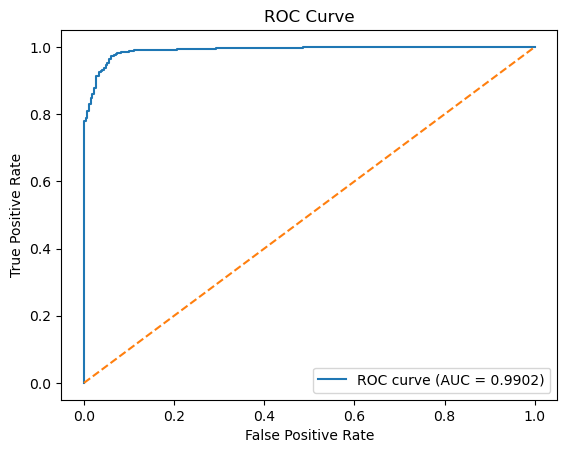

ROC AUC: 0.9901663568330236


In [60]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
# ROC curve

fpr, tpr, thresholds_roc = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("ROC AUC:", roc_auc)

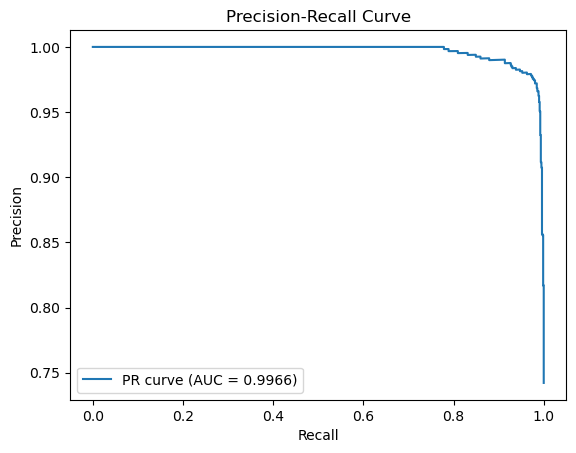

PR AUC: 0.9965812962334998


In [61]:
# Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

print("PR AUC:", pr_auc)

In [62]:
# Find best threshold

best_threshold = 0
best_f1 = 0

for t in thresholds_pr:
    preds = (all_probs >= t).astype(int)
    f1 = f1_score(all_labels, preds)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print("Best Threshold:", best_threshold)
print("Best F1:", best_f1)

Best Threshold: 0.57467973
Best F1: 0.9782608695652174


In [63]:
# New confusion matrix with best threshold
new_preds = (all_probs >= best_threshold).astype(int)

cm_new = confusion_matrix(all_labels, new_preds)

print("New Confusion Matrix:")
print(cm_new)

print("\nClassification Report:")
print(classification_report(all_labels, new_preds, target_names=["Normal", "Pneumonia"]))

New Confusion Matrix:
[[248  22]
 [ 12 765]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.92      0.94       270
   Pneumonia       0.97      0.98      0.98       777

    accuracy                           0.97      1047
   macro avg       0.96      0.95      0.96      1047
weighted avg       0.97      0.97      0.97      1047



**7. Final test set evaluation**

In [71]:
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

In [68]:
# Chosen threshold from validation
final_threshold = 0.5747

model.eval()

all_test_probs = []
all_test_labels = []

with torch.no_grad():
    for images, labels in test_loader:   # test_loader already defined
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = F.softmax(outputs, dim=1)[:, 1]  # probability of Pneumonia

        all_test_probs.extend(probs.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

all_test_probs = np.array(all_test_probs)
all_test_labels = np.array(all_test_labels)


test_preds = (all_test_probs >= final_threshold).astype(int)


cm_test = confusion_matrix(all_test_labels, test_preds)
print("Test Confusion Matrix:")
print(cm_test)


print("\nTest Classification Report:")
print(classification_report(all_test_labels, test_preds, target_names=["Normal", "Pneumonia"]))


test_acc = (test_preds == all_test_labels).sum() / len(all_test_labels)
print(f"\nTest Accuracy: {test_acc:.4f}")

Test Confusion Matrix:
[[114 120]
 [  4 386]]

Test Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.49      0.65       234
   Pneumonia       0.76      0.99      0.86       390

    accuracy                           0.80       624
   macro avg       0.86      0.74      0.75       624
weighted avg       0.84      0.80      0.78       624


Test Accuracy: 0.8013


## Conclusion

In this project, a ResNet-18–based deep learning model was trained to classify chest X-ray images as Normal or Pneumonia. After threshold tuning on the validation set (optimal threshold ≈ 0.57), the model achieved strong validation performance but showed different behavior on the test set.

On the test data, the model achieved:

- **Accuracy:** 80.13%

- **Pneumonia Recall:** 99%

- **Normal Recall:** 49%

### Interpretation of High Pneumonia Recall
The model demonstrates **very high sensitivity (recall) for Pneumonia cases.** This means:

- Almost all actual pneumonia cases were correctly identified.

- Only 4 pneumonia cases were misclassified.

This behavior indicates the model is **highly sensitive to pneumonia-related patterns** in X-ray images. From a medical screening perspective, this can be desirable because missing pneumonia (false negatives) can be more dangerous than over-diagnosing it.

However, this sensitivity comes at a cost.

### Explanation of Low Normal Recall
The low recall for Normal cases (49%) indicates:

- Many Normal images were incorrectly predicted as Pneumonia.

- The model tends to classify borderline or ambiguous images as Pneumonia.

This behavior is likely caused by:

1. **Class imbalance** in the dataset (more Pneumonia cases than Normal cases).

2. **Threshold tuning** optimized to maximize validation performance.

3. The model learning to favor the majority class to reduce overall loss.

As a result, the model is biased toward predicting Pneumonia when uncertain.

### Why Validation Accuracy Was High but Test Accuracy Dropped
The model achieved higher validation accuracy but lower test accuracy (≈80%). This gap suggests:

- The validation set was used to tune the classification threshold.

- The threshold may have slightly overfitted to the validation distribution.

- The test set likely has a slightly different data distribution.

This phenomenon is common in machine learning:

**Threshold optimization on validation data can improve validation metrics but may not generalize perfectly to unseen test data**.

The drop in test accuracy reflects distribution shift and generalization limitations, not necessarily a failure of the model.

### Overall Assessment
Although overall accuracy decreased on the test set, the model achieved:

- Extremely high Pneumonia detection rate (clinical safety benefit)

- Strong F1-score for Pneumonia (0.86)

- Balanced macro F1 of 0.75

The model prioritizes **minimizing false negatives for Pneumonia**, which can be justified in a **medical screening context where detecting disease is more critical than avoiding false alarms.**